In [17]:
from common import NWSL, Data, Fonts, Images, add_twitter_handle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.interpolate import interp1d

In [47]:
season = "2023"

In [48]:
df = Data.get_nwsl_matches(season)
df = df[~df["is_playoffs"]]
matches_per_team = int(len(df.index) / len(df["home"].unique()) * 2)
df

,date,time,season,home,away,home_score,away_score,home_penalty_score,away_penalty_score,home_xg,away_xg,referee,attendance,stadium,is_forfeit,is_extra_time,is_pks,is_playoffs
1106,2023-03-25,14:00,2023,NC,KCC,1,0,NaN,NaN,0.7,0.8,Alex Billeter,4948.0,Sahlen's Stadium at WakeMed Soccer Park,False,False,False,False
1107,2023-03-25,19:00,2023,SD,CHI,3,2,NaN,NaN,2.1,2.5,Elton Garcia,30854.0,Snapdragon Stadium,False,False,False,False
1108,2023-03-26,14:00,2023,POR,ORL,4,0,NaN,NaN,3.7,0.6,Eric Tattersall,15204.0,Providence Park,False,False,False,False
1109,2023-03-26,16:00,2023,WAS,RGN,1,0,NaN,NaN,0.7,2.2,Alyssa Nichols,11281.0,Audi Field,False,False,False,False
1110,2023-03-26,18:00,2023,HOU,LOU,0,0,NaN,NaN,1.3,1.2,Danielle Chesky,5722.0,Shell Energy Stadium,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,2023-10-15,14:00,2023,LA,POR,5,1,NaN,NaN,1.5,0.6,Elvis Osmanovic,22000.0,BMO Stadium,False,False,False,False
1273,2023-10-15,16:00,2023,CHI,RGN,0,3,NaN,NaN,0.3,1.9,Anya Voigt,8004.0,SeatGeek Stadium,False,False,False,False
1274,2023-10-15,17:00,2023,ORL,HOU,1,0,NaN,NaN,3.1,1.2,Natalie Simon,8504.0,Exploria Stadium,False,False,False,False
1275,2023-10-15,17:00,2023,WAS,NC,0,1,NaN,NaN,1.0,1.2,Ricardo Fierro,15479.0,Audi Field,False,False,False,False


In [49]:
team_points = {}

for team in df["home"].unique():
    points = []
    for i, game in df[(df["home"] == team) | (df["away"] == team)].iterrows():
        score = [game["home_score"], game["away_score"]]
        if game["away"] == team:
            score = score[::-1]

        points.append(1 if score[0] == score[1] else (3 if score[0] > score[1] else 0))
    team_points[team] = pd.Series(points)

In [50]:
window_size = 5

df2 = pd.DataFrame(columns=range(0, matches_per_team - window_size + 1))

for team, series in team_points.items():
    windows = series.rolling(window_size)
    moving_sum = windows.sum()
    moving_sum_list = moving_sum.tolist()

    # Remove null entries from the list
    final_list = moving_sum_list[window_size - 1 :]
    df2.loc[team] = pd.Series(final_list)
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
NC,6.0,4.0,7.0,8.0,11.0,8.0,10.0,10.0,12.0,12.0,12.0,9.0,7.0,5.0,2.0,3.0,4.0,6.0
SD,9.0,6.0,6.0,9.0,7.0,10.0,11.0,8.0,5.0,4.0,2.0,4.0,7.0,10.0,10.0,12.0,10.0,10.0
POR,11.0,9.0,6.0,8.0,6.0,8.0,7.0,10.0,10.0,9.0,6.0,9.0,7.0,4.0,7.0,7.0,7.0,6.0
WAS,9.0,9.0,11.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0,7.0,5.0,3.0,3.0,3.0,5.0,5.0,4.0
HOU,6.0,5.0,5.0,4.0,6.0,9.0,10.0,8.0,9.0,6.0,3.0,3.0,3.0,2.0,5.0,8.0,7.0,6.0
LA,5.0,8.0,5.0,5.0,5.0,4.0,1.0,4.0,4.0,5.0,8.0,9.0,9.0,11.0,11.0,8.0,10.0,10.0
KCC,6.0,6.0,6.0,6.0,3.0,3.0,3.0,3.0,6.0,9.0,6.0,9.0,10.0,7.0,7.0,7.0,7.0,7.0
CHI,4.0,4.0,4.0,1.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,10.0,8.0,8.0,8.0,7.0
LOU,4.0,3.0,5.0,7.0,7.0,7.0,8.0,8.0,5.0,6.0,8.0,8.0,6.0,9.0,8.0,5.0,7.0,6.0
NJNY,9.0,9.0,10.0,10.0,8.0,8.0,6.0,5.0,5.0,5.0,8.0,7.0,8.0,6.0,8.0,5.0,5.0,5.0


<Figure size 1728x972 with 0 Axes>

<Figure size 28800x16200 with 0 Axes>

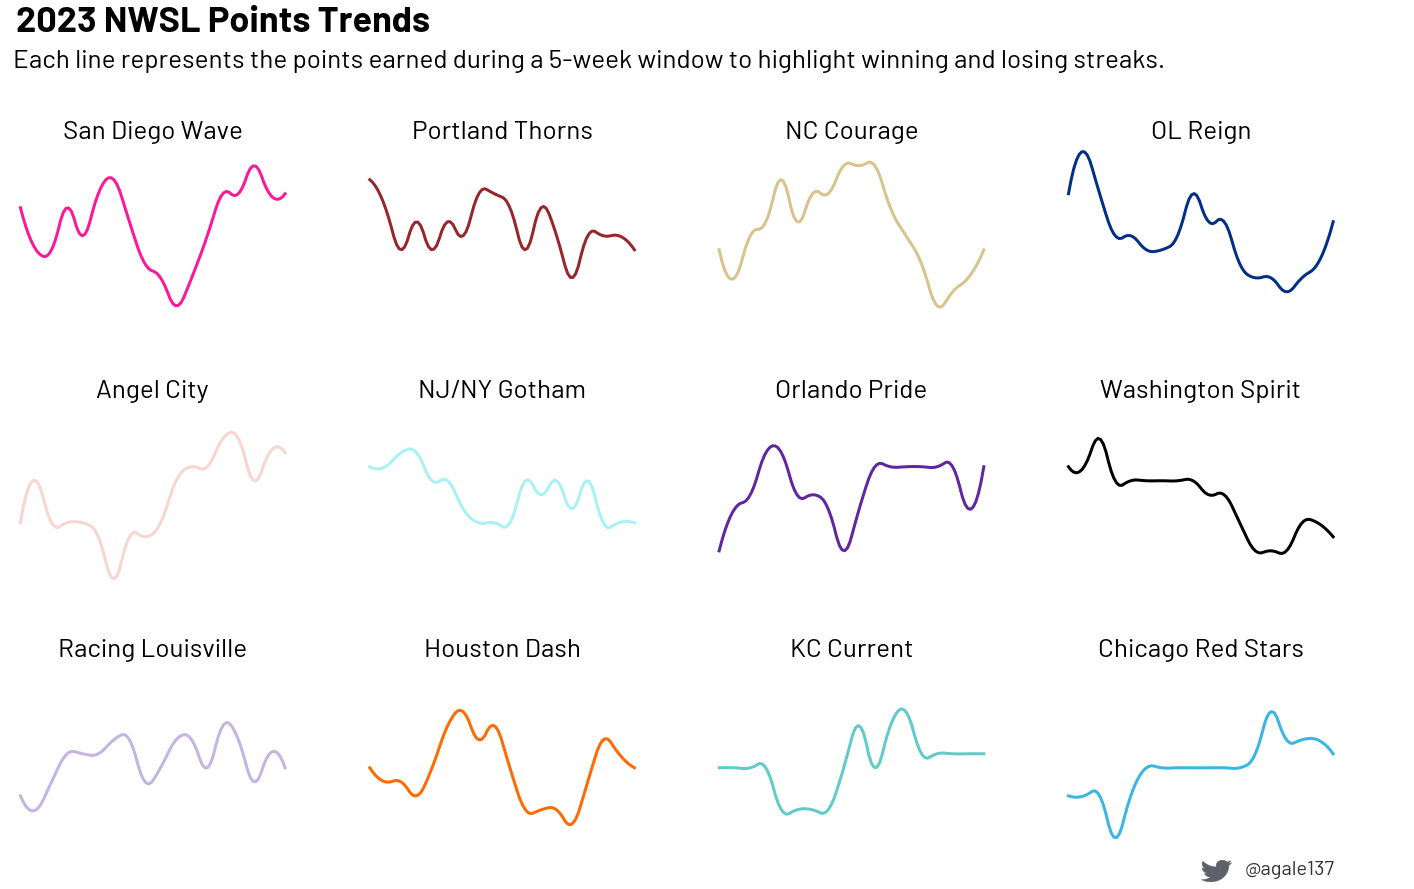

In [51]:
plt.clf()
plt.rcParams["figure.figsize"] = (24, 13.5)
plt.figure(dpi=1200, facecolor="white")
fig, axs = plt.subplots(3, 4)
fig.patch.set_facecolor("white")

smooth = True

# Sort teams to order them by rank
standings = list(
    map(
        lambda t: t[0],
        sorted(
            {k: v.sum() for k, v in team_points.items()}.items(),
            key=lambda kv: kv[1],
            reverse=True,
        ),
    )
)

# Plot each team as a subplot
for i, team in enumerate(standings):
    ax = axs[int(i / 4), i % 4]

    if smooth:
        f = interp1d(list(df2.columns), df2.loc[team].to_numpy(), kind="quadratic")
        x2 = np.linspace(0, 22 - window_size, num=100)
        y2 = f(x2)
        ax.plot(
            x2,
            y2,
            linewidth=3,
            color=NWSL.COLORS[team],
        )
    else:
        ax.plot(
            df2.columns,
            df2.loc[team],
            linewidth=3,
            color=NWSL.COLORS[team],
        )
    ax.set_title(NWSL.NAMES[team], fontproperties=Fonts.BARLOW, size=26, y=0.9)
    ax.axis("off")
    ax.set_ylim([-0.4, 3 * window_size])
    ax.set_xticks([])
    ax.set_yticks([])
    
for i in range(0, 12):
    ax = axs[int(i / 4), i % 4]
    ax.axis("off")

# Title
fig.suptitle(
    season + " NWSL Points Trends",
    fontproperties=Fonts.BARLOW_BOLD,
    size=36,
    ha="left",
    x=0.13,
    y=1,
)

# Subtitle
axs[0, 0].text(
    -0.5,
    19,
    "Each line represents the points earned during a 5-week window to highlight winning and losing streaks.",
    fontproperties=Fonts.BARLOW,
    size=26,
    ha="left",
)

# Twitter logo and username
add_twitter_handle(fig, x=0.81, y=0.1, fs=20, w=0.025)

# Save image
plt.savefig("moving_sum_" + season + ".png", bbox_inches="tight", pad_inches=0.5)